# E-Commerce Analytics & Predictive Modeling
**This project demonstrates the ability to process large datasets, extract meaningful business insights, predict customer behavior, and visualize results—skills directly applicable to data analyst and data scientist roles**

# Importing all the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

# Importing data using pandas

In [6]:
data = pd.read_csv(r"C:\Users\giris\Downloads\synthetic_ecommerce_100k_realistic.csv")

# Inspecting the data

In [7]:
data.head()

,InvoiceNo,StockCode,ProductName,Quantity,InvoiceDate,Price,CustomerID,Country,TotalAmount
0,INV9663,SC3817,Lamp,16,12-01-2024 23:59,424.63,CUST7483,Saint Helena,6794.08
1,INV7227,SC5039,Game,18,24-09-2024 04:23,423.78,CUST8429,Estonia,7628.04
2,INV8910,SC3133,Lamp,5,19-08-2024 01:54,74.37,CUST1680,Cocos (Keeling) Islands,371.85
3,INV9710,SC2996,Watch,2,12-05-2025 07:28,133.69,CUST9262,Rwanda,267.38
4,INV9997,SC2069,Detergent,18,31-07-2024 22:54,77.95,CUST2698,Kazakhstan,1403.10


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    100000 non-null  object 
 1   StockCode    100000 non-null  object 
 2   ProductName  100000 non-null  object 
 3   Quantity     100000 non-null  int64  
 4   InvoiceDate  100000 non-null  object 
 5   Price        100000 non-null  float64
 6   CustomerID   100000 non-null  object 
 7   Country      100000 non-null  object 
 8   TotalAmount  100000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 6.9+ MB


In [10]:
data.describe()

,Quantity,Price,TotalAmount
count,100000.000000,100000.000000,100000.000000
mean,9.986360,252.479462,2523.962125
std,5.483092,142.845021,2143.406240
min,1.000000,5.010000,5.030000
25%,5.000000,128.910000,763.342500
50%,10.000000,252.990000,1911.390000
75%,15.000000,375.942500,3823.470000
max,19.000000,500.000000,9497.340000


In [12]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
ProductName    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
TotalAmount    0
dtype: int64

# feature engineering

In [15]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')
data['InvoiceDay'] = data['InvoiceDate'].dt.day_name()
data['TotalAmount'] = data['Quantity'] * data['Price']

# Exploratory Data Analysis (EDA)

ProductName
Salt         4287841.52
Honey        4269191.68
Toy          4257292.09
Magazine     4243391.09
Detergent    4225680.91
Jam          4225211.96
Pen          4224064.05
Yogurt       4222095.57
Rice         4216897.97
Biscuits     4213350.91
Name: TotalAmount, dtype: float64


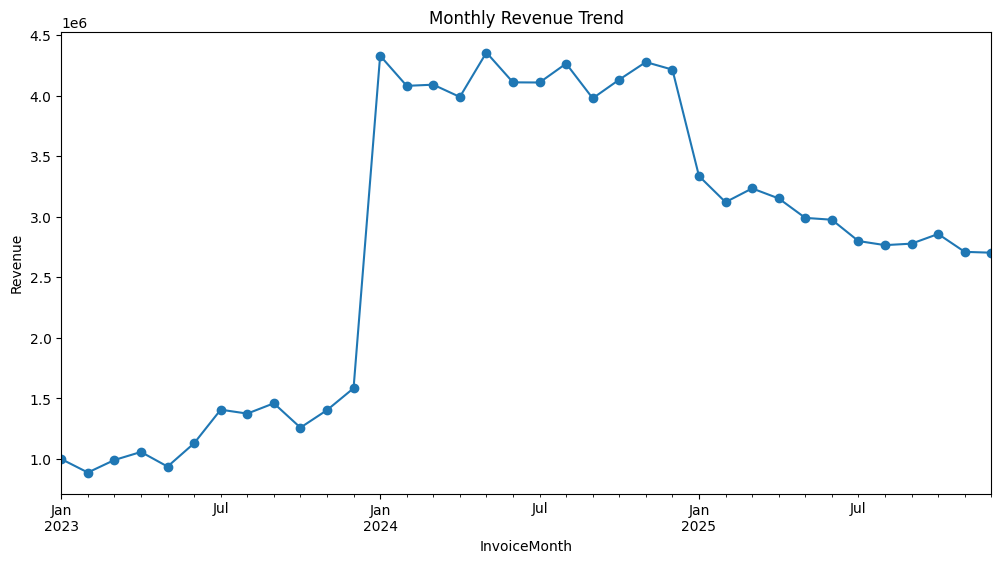

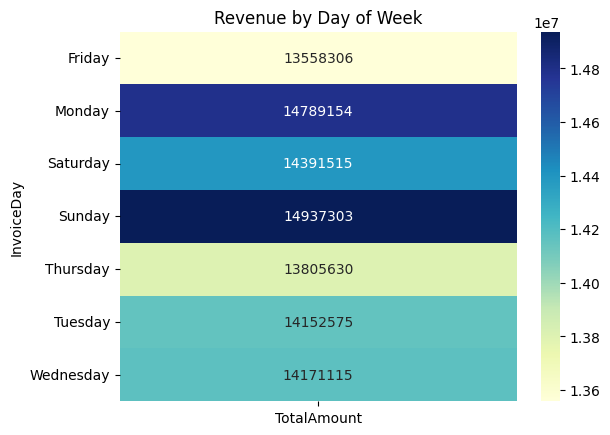

In [16]:
top_products = data.groupby('ProductName')['TotalAmount'].sum().sort_values(ascending=False).head(10)
print(top_products)

monthly_revenue = data.groupby('InvoiceMonth')['TotalAmount'].sum()
monthly_revenue.plot(kind='line', figsize=(12,6), marker='o')
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.show()

sales_day = data.groupby('InvoiceDay')['TotalAmount'].sum()
sns.heatmap(sales_day.to_frame(), annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue by Day of Week")
plt.show()

# Customer Segmentation (RFM Analysis)

In [24]:
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
print(rfm['RFM_Score'])

0       321
1       323
2       443
3       111
4       432
       ... 
8995    312
8996    444
8997    221
8998    112
8999    221
Name: RFM_Score, Length: 9000, dtype: object


# Churn Prediction

In [18]:
rfm['Churn'] = np.where(rfm['Recency'] > 90, 1, 0)

X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
[[ 582    0]
 [   0 1218]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       582
           1       1.00      1.00      1.00      1218

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



# Sales Trend Forecasting (Simple Regression)

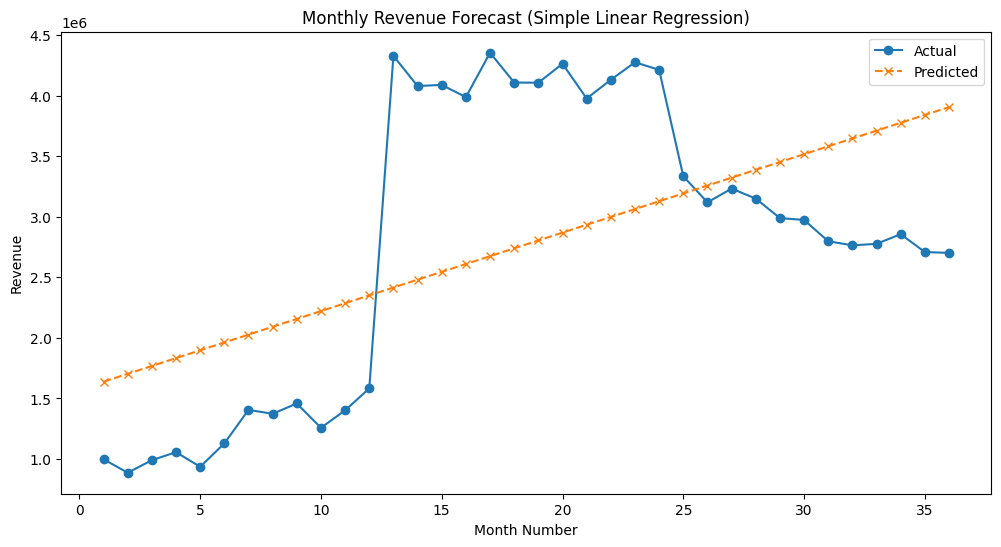

In [22]:
from sklearn.linear_model import LinearRegression
monthly_revenue = data.groupby('InvoiceMonth')['TotalAmount'].sum().reset_index()
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].astype(str)
monthly_revenue['MonthNum'] = range(1, len(monthly_revenue)+1)

X = monthly_revenue[['MonthNum']]
y = monthly_revenue['TotalAmount']

model = LinearRegression()
model.fit(X, y)
monthly_revenue['PredictedRevenue'] = model.predict(X)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue['MonthNum'], monthly_revenue['TotalAmount'], marker='o', label='Actual')
plt.plot(monthly_revenue['MonthNum'], monthly_revenue['PredictedRevenue'], marker='x', linestyle='--', label='Predicted')
plt.title("Monthly Revenue Forecast (Simple Linear Regression)")
plt.xlabel("Month Number")
plt.ylabel("Revenue")
plt.legend()
plt.show()


# Cohort Analysis

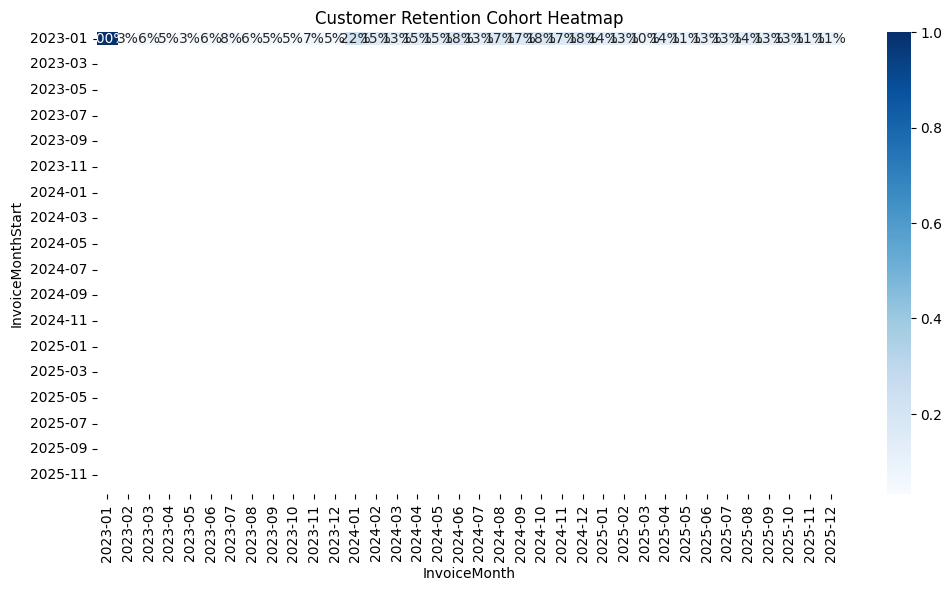

In [23]:
data['InvoiceMonthStart'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
cohort_data = data.groupby(['InvoiceMonthStart','InvoiceMonth'])['CustomerID'].nunique().unstack()
cohort_data = cohort_data.divide(cohort_data.iloc[:,0], axis=0)  # retention %

import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(cohort_data, annot=True, fmt=".0%", cmap="Blues")
plt.title("Customer Retention Cohort Heatmap")
plt.show()


# Top Customers by Total Revenue

Top 10 Customers by Total Revenue:
 CustomerID
CUST8548    80463.00
CUST3389    74397.70
CUST1086    73826.98
CUST3001    73233.19
CUST5104    70982.89
CUST4491    69689.96
CUST4513    69598.47
CUST6512    69256.58
CUST5226    69011.94
CUST4534    68879.08
Name: TotalAmount, dtype: float64


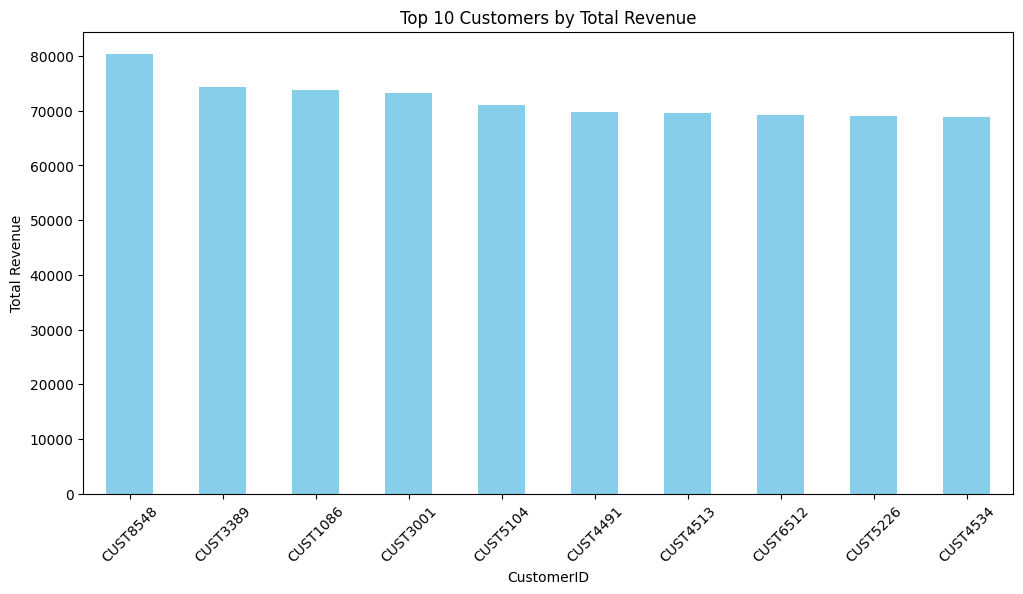

In [26]:
data['TotalAmount'] = data['Quantity'] * data['Price']

customer_revenue = data.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False)

top_customers = customer_revenue.head(10)
print("Top 10 Customers by Total Revenue:\n", top_customers)

plt.figure(figsize=(12,6))
top_customers.plot(kind='bar', color='skyblue')
plt.title("Top 10 Customers by Total Revenue")
plt.ylabel("Total Revenue")
plt.xlabel("CustomerID")
plt.xticks(rotation=45)
plt.show()

# Top Countries by Total Revenue

Top 10 Countries by Total Revenue:
 Country
Korea                           2241110.58
Congo                           1947825.35
Brazil                          1215349.22
United States Virgin Islands    1208579.49
El Salvador                     1190919.01
Cayman Islands                  1182304.29
Chile                           1166637.65
Kazakhstan                      1159312.32
Austria                         1157134.85
Solomon Islands                 1146845.74
Name: TotalAmount, dtype: float64


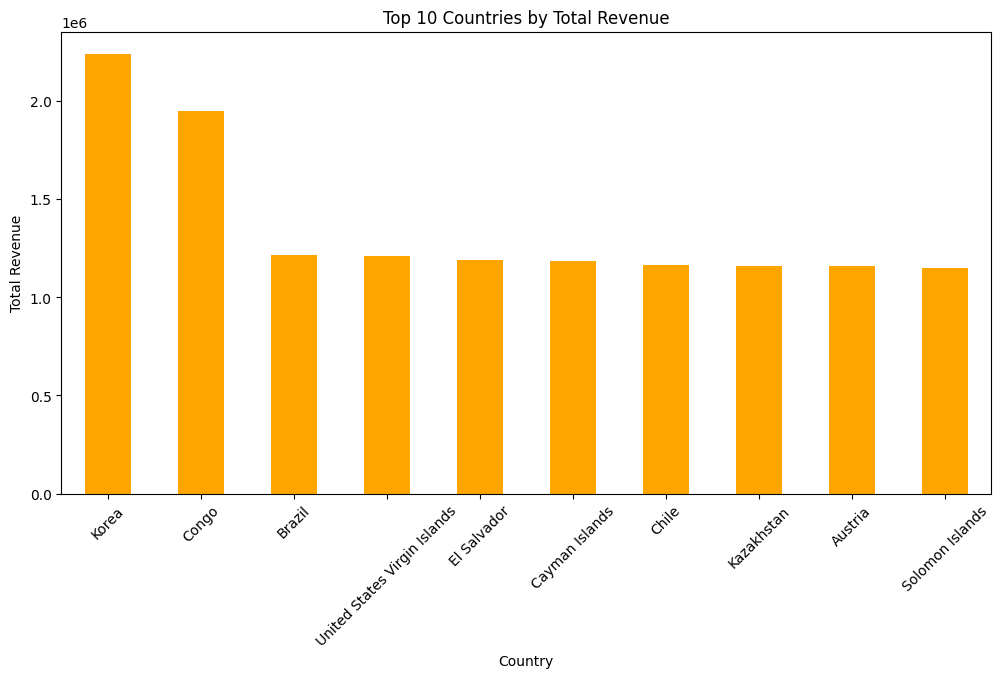

In [28]:
data['TotalAmount'] = data['Quantity'] * data['Price']

country_revenue = data.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)

top_countries = country_revenue.head(10)
print("Top 10 Countries by Total Revenue:\n", top_countries)

plt.figure(figsize=(12,6))
top_countries.plot(kind='bar', color='orange')
plt.title("Top 10 Countries by Total Revenue")
plt.ylabel("Total Revenue")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()